> attempt loading 80_280_500 from run_c

In [5]:
# fullwidth notebook cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# suppress tensorflow FutureWarning
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import h5py
import tensorflow as tf, pandas as pd, numpy as np, matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

In [13]:
data_path = 'data/wrap_data_10000.csv'
data_df = pd.read_csv(data_path, dtype = float)

training_data_df = data_df.sample(frac = 0.8)
testing_data_df = data_df.loc[~data_df.index.isin(training_data_df.index)]

X_training = training_data_df.drop('tau', axis = 1).values
Y_training = training_data_df[['tau']].values

X_testing = testing_data_df.drop('tau', axis = 1).values
Y_testing = testing_data_df[['tau']].values

X_scaler = MinMaxScaler(feature_range = (0,1))
Y_scaler = MinMaxScaler(feature_range = (0,1))

X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)

X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

number_of_inputs = X_scaled_training.shape[1]
number_of_outputs = Y_scaled_training.shape[1]

learning_rate = 0.0015
training_epochs = 250
display_step = 5

layer_1_nodes, layer_2_nodes, layer_3_nodes = 80, 280, 280

In [14]:
tf.reset_default_graph()

# Input Layer
with tf.variable_scope('input'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))

# Layer 1
with tf.variable_scope('layer_1'):

    biases = tf.get_variable(name = "biases1",
                             shape = [layer_1_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights1",
                              shape  = [number_of_inputs, layer_1_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

# Layer 2
with tf.variable_scope('layer_2'):

    biases = tf.get_variable(name = "biases2",
                             shape = [layer_2_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_1_nodes, layer_2_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

# Layer 3
with tf.variable_scope('layer_3'):

    biases = tf.get_variable(name = "biases3",
                             shape = [layer_3_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights3",
                              shape  = [layer_2_nodes, layer_3_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

# Output layer

with tf.variable_scope('output'):

    biases = tf.get_variable(name = "biases_out",
                             shape = [number_of_outputs],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights_out",
                              shape  = [layer_3_nodes, number_of_outputs],
                         initializer = tf.contrib.layers.xavier_initializer())


    prediction = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)

with tf.variable_scope('cost'):

    Y = tf.placeholder(tf.float32, shape = (None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))


with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-05).minimize(cost)

with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()




In [17]:
saver = tf.train.Saver()
session = tf.Session()

# When loading from a checkpoint, don't initialize the variables!
# Instead, load them from disk:
saver.restore(session, "logs/run_c/80_280_500model/trained_model.ckpt")

Y_predicted_scaled = session.run(prediction, feed_dict={X: X_scaled_testing})

# Unscale the data back to it's original units (dollars)
Y_predicted = Y_scaler.inverse_transform(Y_predicted_scaled)



INFO:tensorflow:Restoring parameters from logs/run_c/80_280_500model/trained_model.ckpt


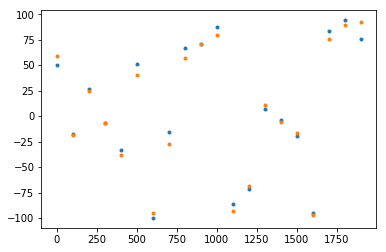

In [45]:
plt.plot(range(len(Y_predicted.T[0]))[::100], (Y_predicted.T[0])[::100], ls = 'none', markersize = 3, marker = 'o')
plt.plot(range(len(Y_predicted.T[0]))[::100], (Y_testing)[::100], ls = 'none', markersize = 3, marker = 'o')
plt.show()

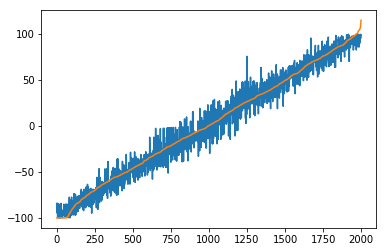

In [53]:
sorting_index = np.argsort(Y_testing.T[0])
sorting_index = np.argsort(Y_predicted.T[0])


plt.plot(Y_testing.T[0][sorting_index])
plt.plot(Y_predicted.T[0][sorting_index])
plt.show()

In [50]:
Y_testing.T[0]

array([ 58.67720444,  65.72185064,  55.97903083, ..., -15.47949471,
        -3.78856963,  12.81497706])